In [6]:
!pip install python-louvain

In [41]:
import pandas as pd
import networkx as nx
import math
import collections
import torch
import numpy as np

from community import community_louvain
import tskit

import matplotlib.pyplot as plt

import cartopy
import cartopy.crs as ccrs

In [8]:
# Download the tree sequence from here: https://drive.google.com/drive/folders/15pvB_F0-hB4xYVKrTRhCVfeJymsZPSM9?usp=sharing
ts = tskit.load("/Users/anthonywohns/Downloads/hgdp_sgdp_high_cov_ancients_chr20.dated.trees")

In [32]:
# Grab the locations of samples
modern_sample_locations = torch.as_tensor(ts.tables.individuals.location.reshape((ts.num_individuals-8, 2)))
print(modern_sample_locations.shape)
# Need to reshape because num_samples = 2 * num_individuals, and locations are stored per individual
modern_sample_locations = modern_sample_locations.reshape(-1, 1, 2).expand(-1, 2, 2).reshape(-1, 2)
print(modern_sample_locations.shape)

torch.Size([1206, 2])
torch.Size([2412, 2])


In [27]:
# Functions borrowed from https://github.com/tskit-dev/what-is-an-arg-paper

def convert_nx(ts, mutation_rate=1e-8):
    """
    Returns the specified tree sequence as an networkx directed graph.
    Weights are the edge's total span * e^(-edge length * mutation_rate).

    Mutation rate is in units: probability of mutation per base pair per generation.
    """
    G = nx.Graph()
    edges = collections.defaultdict(list)
    times = ts.tables.nodes.time
    for edge in ts.edges():
        edges[(edge.child, edge.parent)].append((edge.left, edge.right, times[edge.parent], times[edge.child]))
    for node in ts.nodes():
        G.add_node(node.id, time=node.time, flags=node.flags)
    for edge, intervals in edges.items():
        G.add_edge(*edge, weight=sum((right - left) * math.e**(-(top-bottom) * mutation_rate) for
                                     (left, right, top, bottom) in intervals))

    return G

In [28]:
graph = convert_nx(ts)
graph.number_of_nodes(), graph.number_of_edges()

(443679, 2876017)

In [44]:
partition = community_louvain.best_partition(graph, weight="weight", resolution=1) # resolution > 1: fewer clusters. < 1: more clusters

In [36]:
assignment = np.array(list(partition.values()))[ts.samples()][:-16] # hack since 8 individual ancient locations aren't included

In [38]:
# Make dictionary where key=community and value=nodes in community
partition_dict = collections.defaultdict(list)
for key, val in partition.items():
    partition_dict[val].append(key)

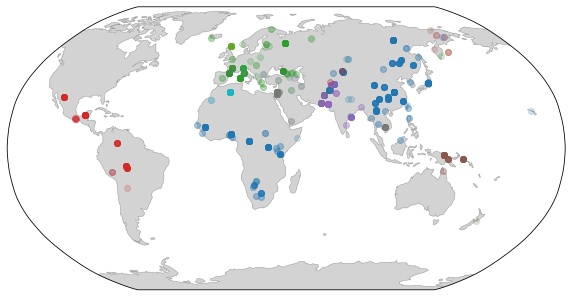

In [42]:
def plot(locations, assignment, clusters):
    assert len(locations) == len(assignment)
    locations = torch.as_tensor(locations)
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=41))
    ax.coastlines(linewidth=0.1)
    ax.add_feature(cartopy.feature.LAND, facecolor="lightgray")
    ax.set_global()
    for c in range(clusters.shape[0]):
        y, x = locations[assignment == c].unbind(-1)
        ax.scatter(x.numpy(), y.numpy(), alpha=0.1, transform=ccrs.PlateCarree())
        
plot(modern_sample_locations, assignment, np.arange(len(partition_dict)))